In [ ]:
pip install pandas numpy sckikit-learn xgboost

ERROR: Could not find a version that satisfies the requirement sckikit-learn (from versions: none)
ERROR: No matching distribution found for sckikit-learn


In [8]:
!pip install mpld3



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 3.2 MB/s eta 0:00:00


In [9]:
import pandas as pd
import numpy as np
import mpld3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, auc
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE




In [2]:
from google.colab import files

uploaded = files.upload()

Saving day_approach_maskedID_timeseries.csv to day_approach_maskedID_timeseries.csv


In [3]:
# Load the daily approach dataset
daily_file_path = 'day_approach_maskedID_timeseries.csv'  # Use the correct file name from upload
daily_data = pd.read_csv(daily_file_path)

# Preprocessing for the Daily Approach
daily_data = daily_data.dropna()  # Drop rows with missing values (if any)



In [4]:
# Define the feature columns and target variable for the daily approach
features_daily = ['nr. sessions', 'total km', 'km Z3-4', 'km Z5-T1-T2', 'km sprinting',
                  'strength training', 'hours alternative', 'perceived exertion', 'perceived trainingSuccess',
                  'perceived recovery', 'nr. sessions.1', 'total km.1', 'km Z3-4.1', 'km Z5-T1-T2.1',
                  'km sprinting.1', 'strength training.1', 'hours alternative.1', 'perceived exertion.1',
                  'perceived trainingSuccess.1', 'perceived recovery.1', 'nr. sessions.2', 'total km.2',
                  'km Z3-4.2', 'km Z5-T1-T2.2', 'km sprinting.2', 'strength training.2', 'hours alternative.2',
                  'perceived exertion.2', 'perceived trainingSuccess.2', 'perceived recovery.2']  # Example of features
target_daily = 'injury'  # The target variable indicating if injury occurred (0: no injury, 1: injury)


# Prepare the data for the daily approach
X_daily = daily_data[features_daily]
y_daily = daily_data[target_daily]


In [ ]:

# SMOTE for balancing the dataset
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X_daily, y_daily)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.3, random_state=0)


KNN Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92     12498
           1       0.88      0.98      0.93     12812

    accuracy                           0.92     25310
   macro avg       0.93      0.92      0.92     25310
weighted avg       0.93      0.92      0.92     25310



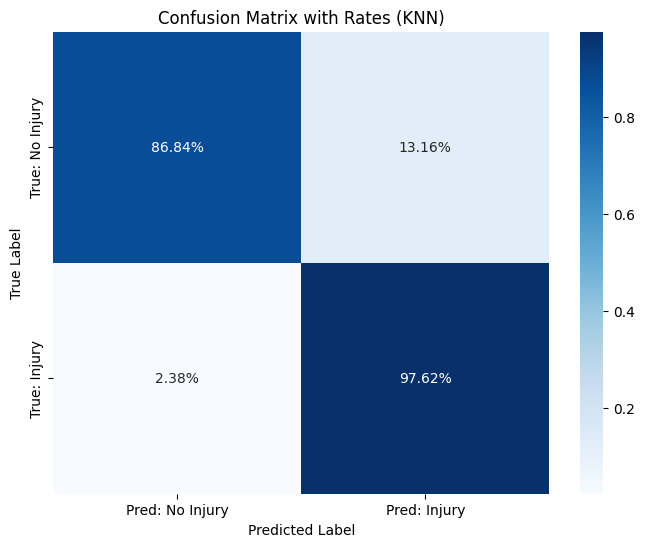

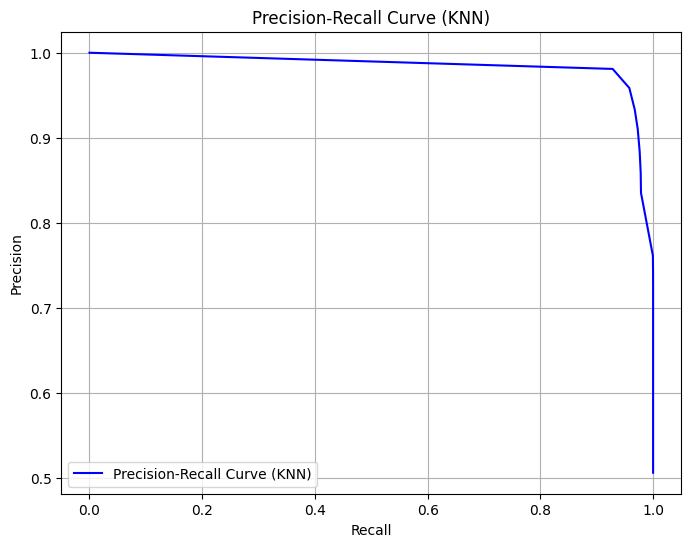

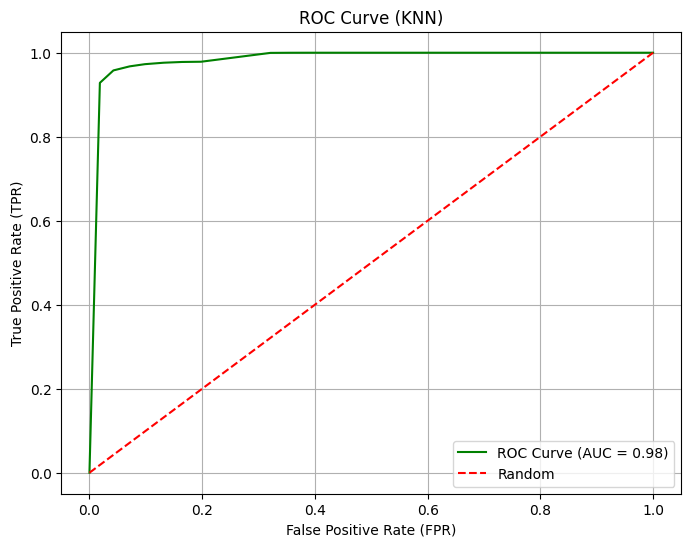

Optimal Threshold (ROC): 0.9


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Fit the KNN model
knn = KNeighborsClassifier(n_neighbors=10, metric='minkowski', p=2)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
y_prob_knn = knn.predict_proba(X_test)[:, 1]

# KNN Evaluation
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

# Confusion Matrix for KNN
confm_knn = confusion_matrix(y_test, y_pred_knn)

# Calculate confusion matrix rates (percentage values)
confm_knn_rate = confm_knn.astype('float') / confm_knn.sum(axis=1)[:, np.newaxis]

# Plot Confusion Matrix with rates
plt.figure(figsize=(8, 6))
sns.heatmap(confm_knn_rate, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Pred: No Injury', 'Pred: Injury'], yticklabels=['True: No Injury', 'True: Injury'])
plt.title('Confusion Matrix with Rates (KNN)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Precision-Recall curve for KNN (Precision on Y, Recall on X)
precision_knn, recall_knn, thresholds_pr = precision_recall_curve(y_test, y_prob_knn)
plt.figure(figsize=(8, 6))
plt.plot(recall_knn, precision_knn, label="Precision-Recall Curve (KNN)", color='b')
plt.title("Precision-Recall Curve (KNN)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

# ROC Curve for KNN
fpr_knn, tpr_knn, thresholds_roc = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, label=f"ROC Curve (AUC = {roc_auc_knn:.2f})", color='g')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.title("ROC Curve (KNN)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend()
plt.grid(True)
plt.show()

# Calculate optimal threshold based on the ROC curve
optimal_threshold = thresholds_roc[np.argmax(tpr_knn - fpr_knn)]
print(f"Optimal Threshold (ROC): {optimal_threshold}")

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.95      0.87     12498
           1       0.94      0.78      0.86     12812

    accuracy                           0.87     25310
   macro avg       0.88      0.87      0.86     25310
weighted avg       0.88      0.87      0.86     25310



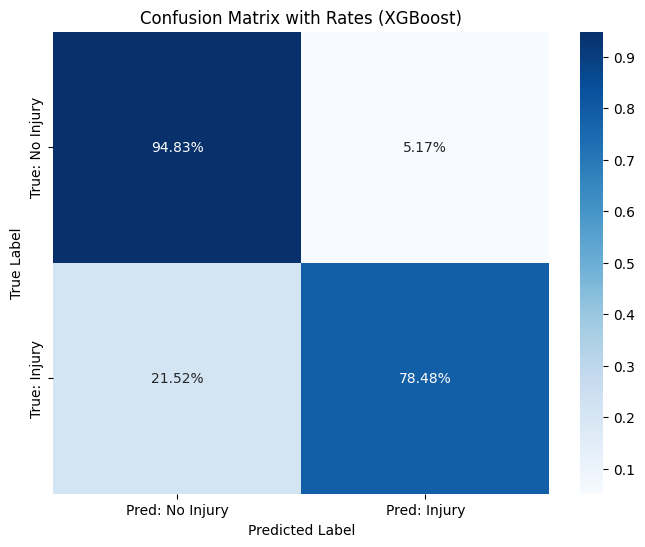

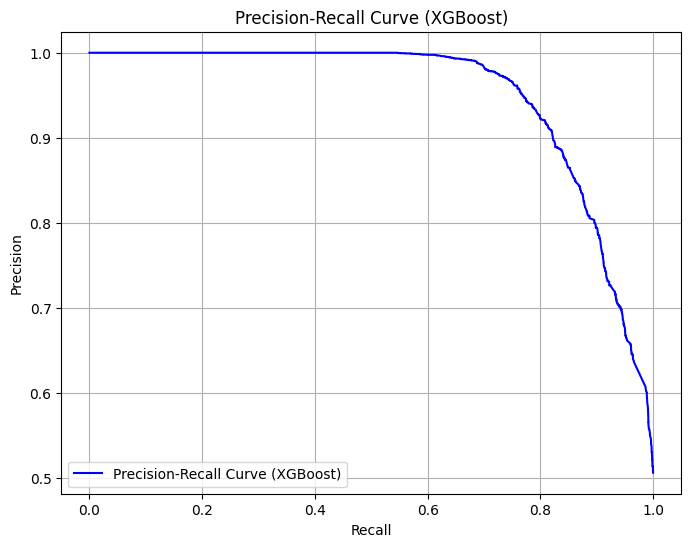

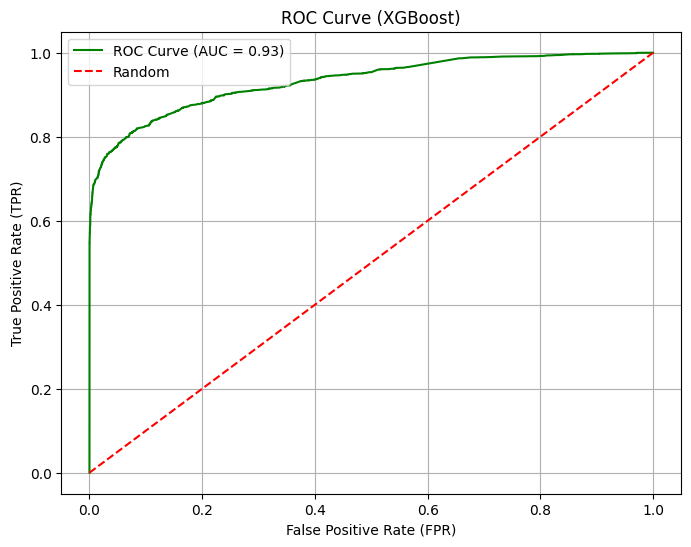

Optimal Threshold (ROC): 0.47349676489830017


In [ ]:
from xgboost import XGBClassifier

# 2. XGBoost Model
boost = XGBClassifier(max_depth=2, n_estimators=30, random_state=42)
boost.fit(X_train, y_train)
y_pred_boost = boost.predict(X_test)
y_prob_boost = boost.predict_proba(X_test)[:, 1]

# XGBoost Evaluation
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_boost))

# Confusion Matrix for XGBoost
confm_boost = confusion_matrix(y_test, y_pred_boost)
confm_boost_rate = confm_boost.astype('float') / confm_boost.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(confm_boost_rate, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Pred: No Injury', 'Pred: Injury'], yticklabels=['True: No Injury', 'True: Injury'])
plt.title('Confusion Matrix with Rates (XGBoost)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Precision-Recall curve for XGBoost (Precision on Y, Recall on X)
precision_boost, recall_boost, thresholds_pr= precision_recall_curve(y_test, y_prob_boost)
plt.figure(figsize=(8, 6))
plt.plot(recall_boost, precision_boost, label="Precision-Recall Curve (XGBoost)", color='b')
plt.title("Precision-Recall Curve (XGBoost)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

# ROC Curve for XGBoost
fpr_boost, tpr_boost, thresholds_roc= roc_curve(y_test, y_prob_boost)
roc_auc_boost = auc(fpr_boost, tpr_boost)
plt.figure(figsize=(8, 6))
plt.plot(fpr_boost, tpr_boost, label=f"ROC Curve (AUC = {roc_auc_boost:.2f})", color='g')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.title("ROC Curve (XGBoost)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend()
plt.grid(True)
plt.show()

# Calculate optimal threshold based on the ROC curve
optimal_threshold = thresholds_roc[np.argmax(tpr_boost - fpr_boost)]
print(f"Optimal Threshold (ROC): {optimal_threshold}")

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.62      0.61     12498
           1       0.62      0.60      0.61     12812

    accuracy                           0.61     25310
   macro avg       0.61      0.61      0.61     25310
weighted avg       0.61      0.61      0.61     25310



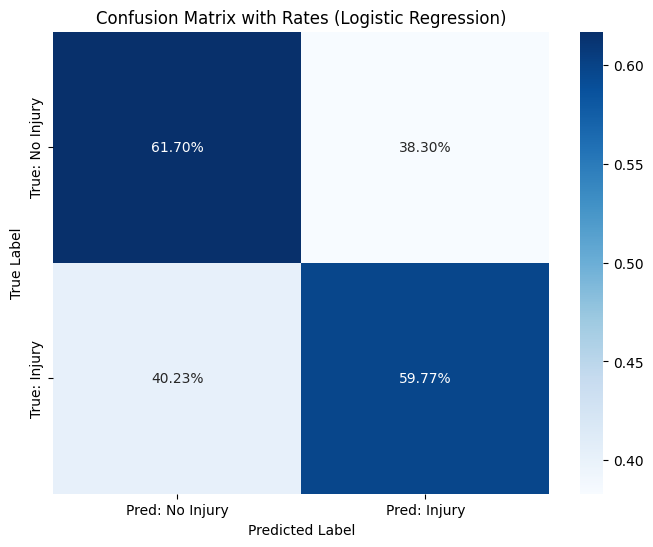

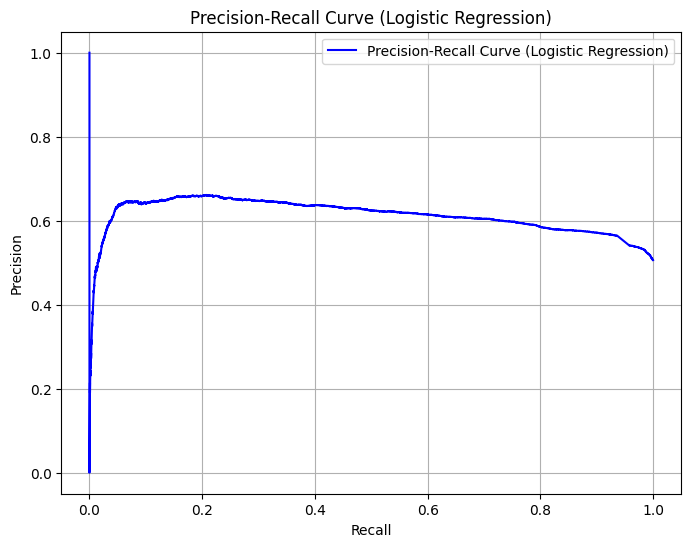

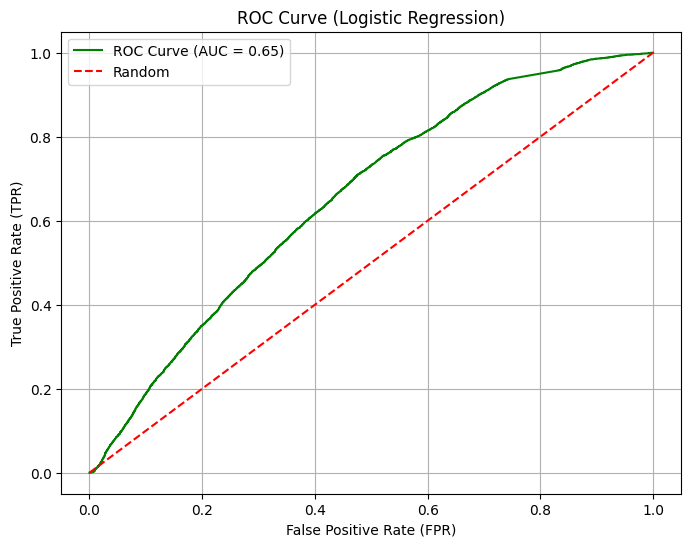

In [ ]:
# 3. Logistic Regression Model
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

# Logistic Regression Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix for Logistic Regression
confm_lr = confusion_matrix(y_test, y_pred_lr)
confm_lr_rate = confm_lr.astype('float') / confm_lr.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(confm_lr_rate, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Pred: No Injury', 'Pred: Injury'], yticklabels=['True: No Injury', 'True: Injury'])
plt.title('Confusion Matrix with Rates (Logistic Regression)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Precision-Recall curve for Logistic Regression (Precision on Y, Recall on X)
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_prob_lr)
plt.figure(figsize=(8, 6))
plt.plot(recall_lr, precision_lr, label="Precision-Recall Curve (Logistic Regression)", color='b')
plt.title("Precision-Recall Curve (Logistic Regression)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

# ROC Curve for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"ROC Curve (AUC = {roc_auc_lr:.2f})", color='g')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.title("ROC Curve (Logistic Regression)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend()
plt.grid(True)
plt.show()


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     12498
           1       1.00      0.97      0.98     12812

    accuracy                           0.98     25310
   macro avg       0.98      0.98      0.98     25310
weighted avg       0.98      0.98      0.98     25310



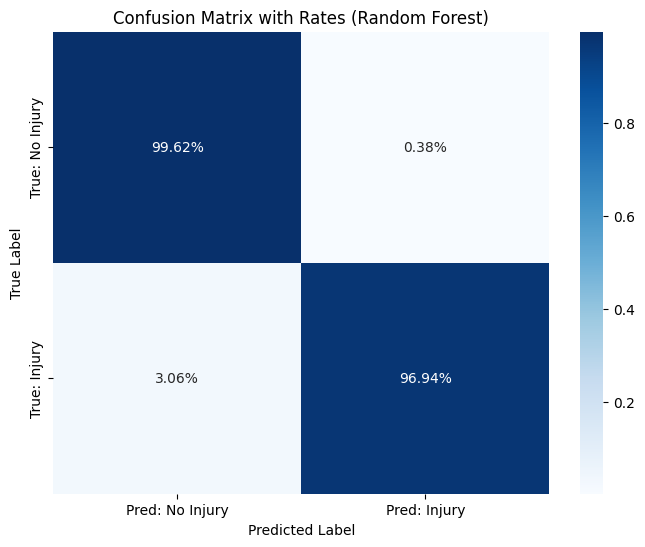

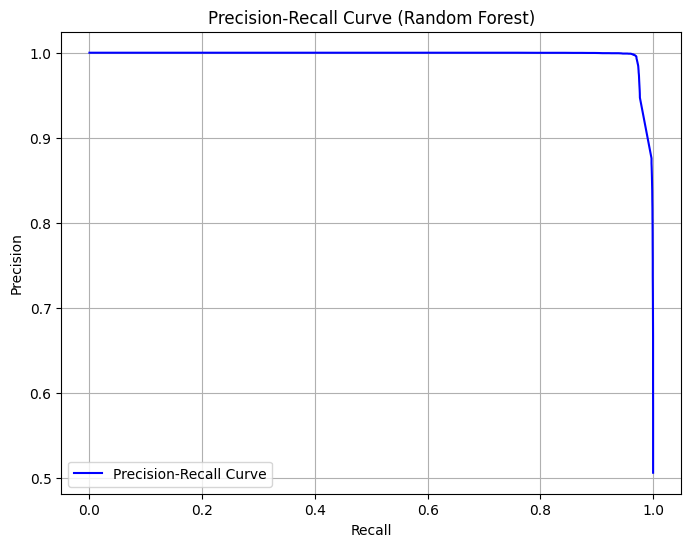

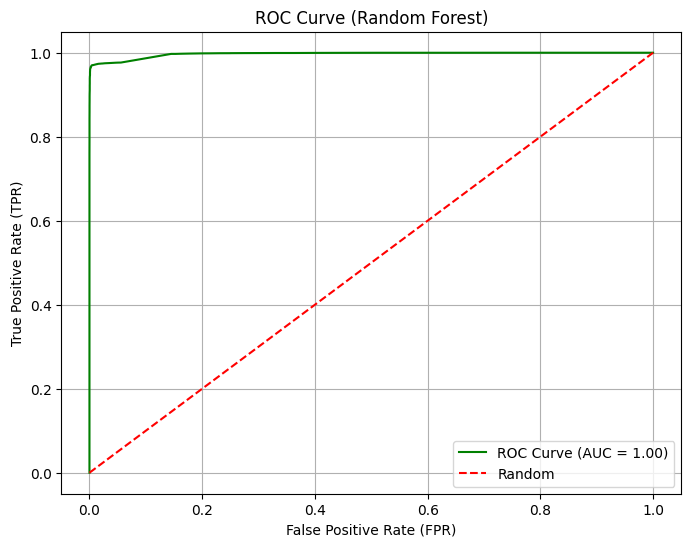

Optimal Threshold (ROC): 0.49
True Positive Rate (TPR) for Random Forest: 0.9694


In [ ]:


# Random Forest Model
rf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (Injury)

# Random Forest Evaluation - Classification Report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
confm_rf = confusion_matrix(y_test, y_pred_rf)
confm_rf_rate = confm_rf.astype('float') / confm_rf.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(confm_rf_rate, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Pred: No Injury', 'Pred: Injury'], yticklabels=['True: No Injury', 'True: Injury'])
plt.title('Confusion Matrix with Rates (Random Forest)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Precision-Recall Curve
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_prob_rf)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, label="Precision-Recall Curve", color='b')
plt.title("Precision-Recall Curve (Random Forest)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

# ROC Curve
fpr_rf, tpr_rf, thresholds_roc = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"ROC Curve (AUC = {roc_auc_rf:.2f})", color='g')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.title("ROC Curve (Random Forest)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend()
plt.grid(True)
plt.show()

# Calculate optimal threshold based on the ROC curve
optimal_threshold = thresholds_roc[np.argmax(tpr_rf - fpr_rf)]
print(f"Optimal Threshold (ROC): {optimal_threshold}")

# Extract True Positives (TP) and False Negatives (FN) from the confusion matrix
TP = confm_rf[1, 1]  # True Positive: bottom right
FN = confm_rf[1, 0]  # False Negative: bottom left

# Calculate True Positive Rate (TPR)
TPR = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"True Positive Rate (TPR) for Random Forest: {TPR:.4f}")



In [ ]:
print(daily_data.columns)

Index(['nr. sessions', 'total km', 'km Z3-4', 'km Z5-T1-T2', 'km sprinting',
       'strength training', 'hours alternative', 'perceived exertion',
       'perceived trainingSuccess', 'perceived recovery', 'nr. sessions.1',
       'total km.1', 'km Z3-4.1', 'km Z5-T1-T2.1', 'km sprinting.1',
       'strength training.1', 'hours alternative.1', 'perceived exertion.1',
       'perceived trainingSuccess.1', 'perceived recovery.1', 'nr. sessions.2',
       'total km.2', 'km Z3-4.2', 'km Z5-T1-T2.2', 'km sprinting.2',
       'strength training.2', 'hours alternative.2', 'perceived exertion.2',
       'perceived trainingSuccess.2', 'perceived recovery.2', 'nr. sessions.3',
       'total km.3', 'km Z3-4.3', 'km Z5-T1-T2.3', 'km sprinting.3',
       'strength training.3', 'hours alternative.3', 'perceived exertion.3',
       'perceived trainingSuccess.3', 'perceived recovery.3', 'nr. sessions.4',
       'total km.4', 'km Z3-4.4', 'km Z5-T1-T2.4', 'km sprinting.4',
       'strength training.4',

<ipython-input-14-847b289c2cea>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(feature)[target].value_counts(normalize=True).unstack(fill_value=0)
/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
/usr/local/lib/pytho

✔️ Saved: /content/day_approach_strength_training.html


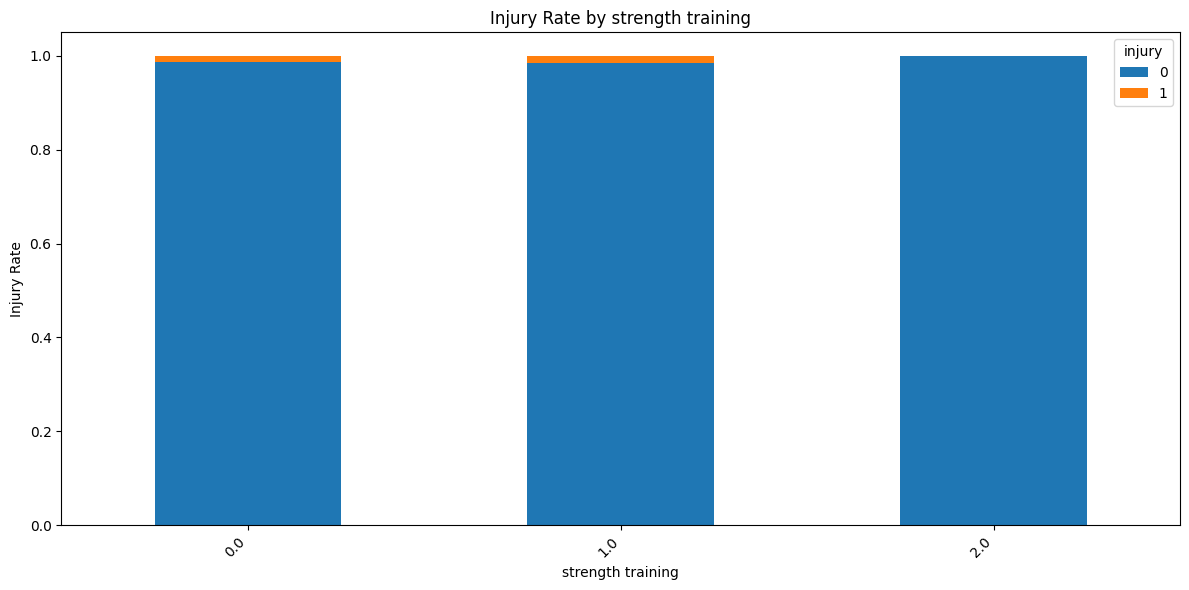

<ipython-input-14-847b289c2cea>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(feature)[target].value_counts(normalize=True).unstack(fill_value=0)
/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
/usr/local/lib/pytho

✔️ Saved: /content/day_approach_nr._sessions.html


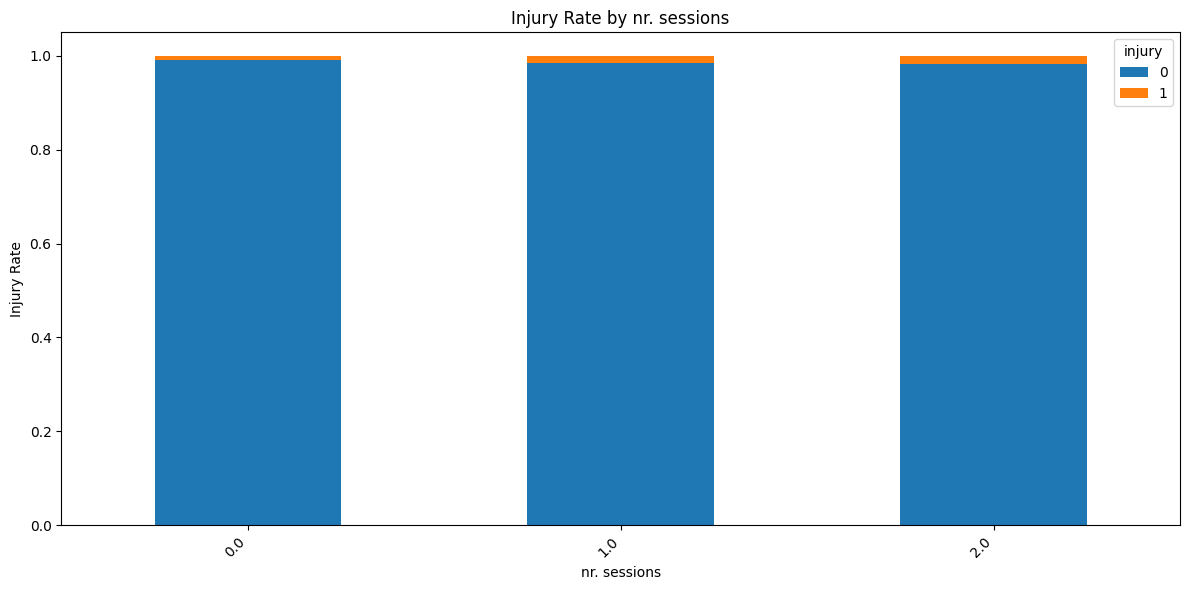

In [14]:
import matplotlib.pyplot as plt

def analyze_feature_impact_without_bins(df, feature, target):
    import mpld3

    if df[feature].isnull().sum() > 0 or df[target].isnull().sum() > 0:
        print(f"Warning: Missing values found in {feature} or {target}")

    if df[feature].dtype not in ['category', 'object']:
        df[feature] = df[feature].astype('category')

    grouped = df.groupby(feature)[target].value_counts(normalize=True).unstack(fill_value=0)
    ax = grouped.plot(kind='bar', stacked=True, figsize=(12, 6), color=['#1f77b4', '#ff7f0e'])

    plt.title(f"Injury Rate by {feature}")
    plt.ylabel("Injury Rate")
    plt.xlabel(feature)
    plt.xticks(ticks=range(len(grouped)), labels=grouped.index)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # ✅ Write to the main Colab folder
    file_path = f"/content/day_approach_{feature.replace(' ', '_')}.html"
    html_str = mpld3.fig_to_html(plt.gcf())
    with open(file_path, "w") as f:
        f.write(html_str)

    print(f"Saved: {file_path}")
    plt.show()



# Example usage:
# Analyze the impact of 'strength training' on injury rate (for daily dataset)
analyze_feature_impact_without_bins(daily_data, 'strength training', 'injury')

# Analyze the impact of 'nr. sessions' on injury rate (for daily dataset)
analyze_feature_impact_without_bins(daily_data, 'nr. sessions', 'injury')



<ipython-input-13-50eb9b2e53f3>:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(feature)[target].value_counts(normalize=True).unstack(fill_value=0)


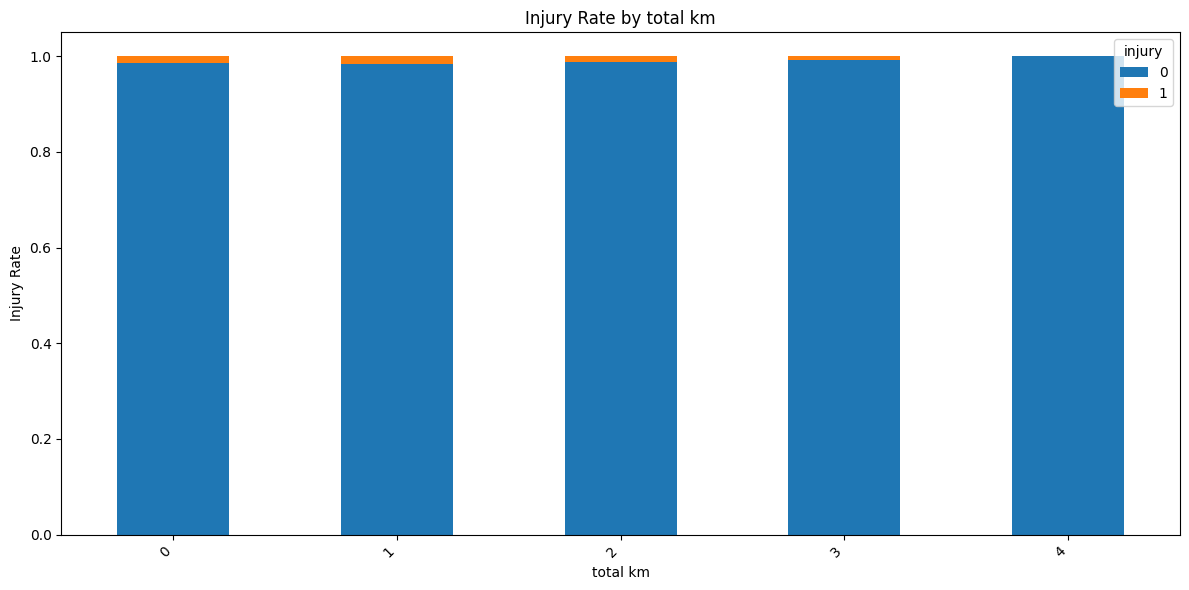

<ipython-input-13-50eb9b2e53f3>:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(feature)[target].value_counts(normalize=True).unstack(fill_value=0)


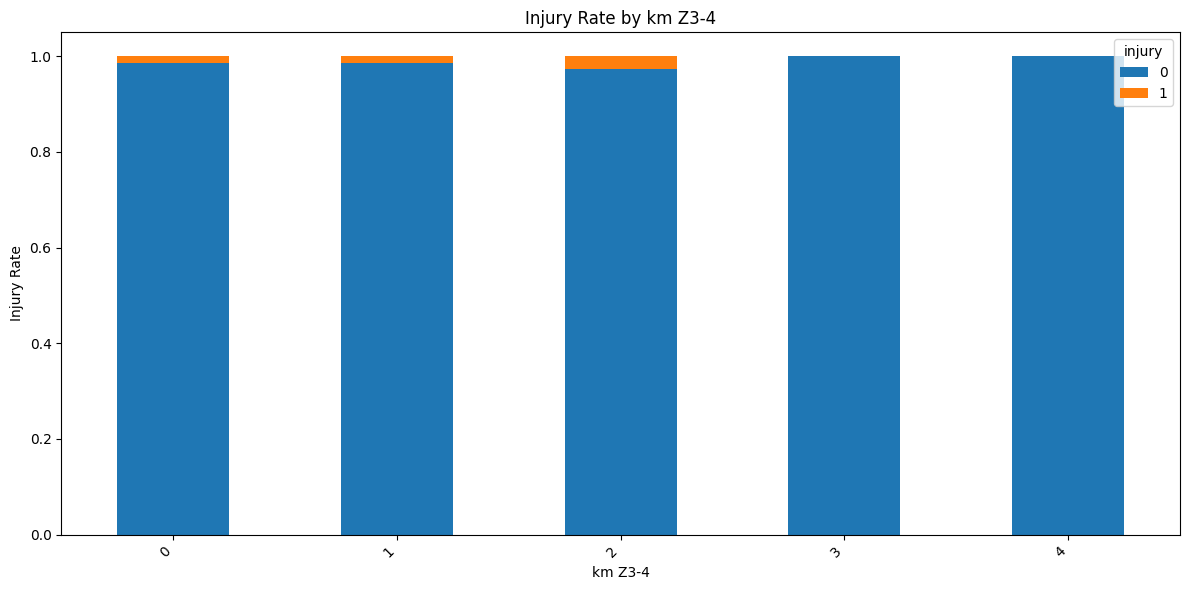

<ipython-input-13-50eb9b2e53f3>:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(feature)[target].value_counts(normalize=True).unstack(fill_value=0)


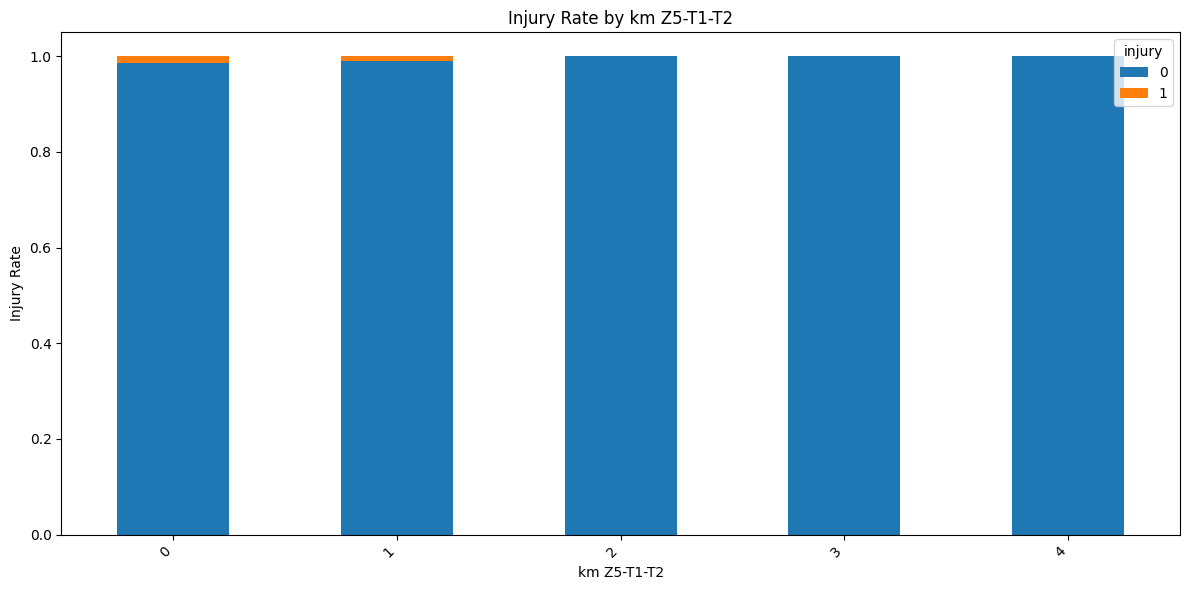

perceived trainingSuccess    0
injury                       0
dtype: int64


<ipython-input-13-50eb9b2e53f3>:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(feature)[target].value_counts(normalize=True).unstack(fill_value=0)


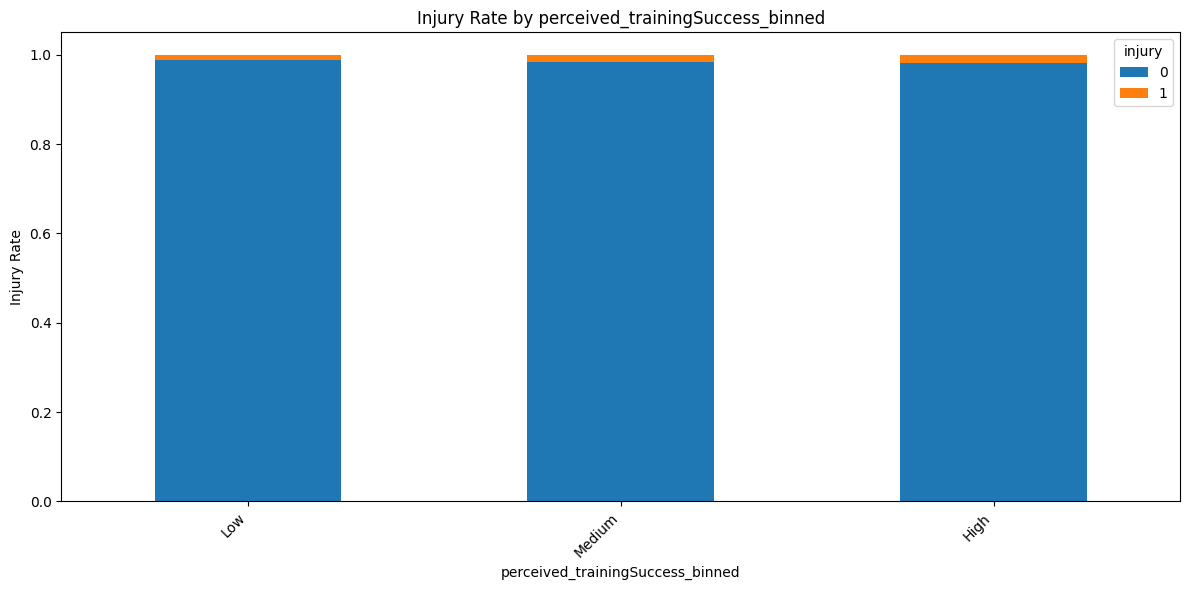

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_feature_impact_with_bins(df, feature, target, bins=None):
    """
    Analyzes the impact of a given feature (including continuous variables binned) on the injury rate.
    Args:
    - df (pd.DataFrame): The dataset
    - feature (str): The feature column name
    - target (str): The target column name (usually 'injury')
    - bins (int or sequence): The number of bins or bin edges for the continuous feature (default=None for no binning)
    """
    # Check for missing values in feature or target columns
    if df[feature].isnull().sum() > 0 or df[target].isnull().sum() > 0:
        print(f"Warning: Missing values found in {feature} or {target}")

    # If the feature is continuous and bins are provided, bin the feature
    if bins is not None and df[feature].dtype in ['float64', 'int64']:
        df[feature] = pd.cut(df[feature], bins=bins, labels=False, include_lowest=True)

    # Convert the feature to category if it's discrete (like strength training, nr. sessions)
    if df[feature].dtype in ['int64', 'float64']:
        df[feature] = df[feature].astype('category')

    # Group by the feature and calculate the injury rate per group
    grouped = df.groupby(feature)[target].value_counts(normalize=True).unstack(fill_value=0)

    # Plot the injury rate by feature group
    ax = grouped.plot(kind='bar', stacked=True, figsize=(12, 6), color=['#1f77b4', '#ff7f0e'])

    # Adjust x-axis labels
    plt.title(f"Injury Rate by {feature}")
    plt.ylabel("Injury Rate")
    plt.xlabel(feature)

    # Rotate x-axis labels and adjust spacing
    plt.xticks(rotation=45, ha='right')  # Rotate labels and set alignment
    plt.tight_layout()  # Ensure that labels don't get cut off

    plt.show()


# Apply bins for continuous features (e.g., 'total km')
analyze_feature_impact_with_bins(daily_data, 'total km', 'injury', bins=[0, 5, 15, 27.9])  # Example for total km

# Apply bins for other continuous features like 'km Z3-4' and 'km Z5-T1-T2'
analyze_feature_impact_with_bins(daily_data, 'km Z3-4', 'injury', bins=[0, 2, 5, 10])  # Example for km Z3-4

analyze_feature_impact_with_bins(daily_data, 'km Z5-T1-T2', 'injury', bins=[0, 1, 3, 6])  # Example for km Z5-T1-T2

# Analyze the impact of 'perceived trainingSuccess' on injury rate
# Binning for perceived trainingSuccess based on the valid range
bins = [-0.01, 0.33, 0.66, 1]  # Define the bins
labels = ['Low', 'Medium', 'High']  # Labels for each bin

# Load the dataset
daily_file_path = 'day_approach_maskedID_timeseries.csv'  # Use the correct file name from upload
df = pd.read_csv(daily_file_path)

# Check for missing values in the relevant columns
print(df[['perceived trainingSuccess', 'injury']].isnull().sum())

# Option 1: Drop rows with missing values in 'perceived trainingSuccess' or 'injury'
df_cleaned = df.dropna(subset=['perceived trainingSuccess', 'injury'])

# Option 2: If you prefer to fill missing values, you can use:
# df['perceived trainingSuccess'].fillna(df['perceived trainingSuccess'].mean(), inplace=True)
# df['injury'].fillna(0, inplace=True)  # If injury column has missing values, fill with 0 (indicating no injury)

# Apply the binning after cleaning data
df_cleaned['perceived_trainingSuccess_binned'] = pd.cut(df_cleaned['perceived trainingSuccess'], bins=bins, labels=labels)

# Perform the analysis using the cleaned data
analyze_feature_impact_with_bins(df_cleaned, 'perceived_trainingSuccess_binned', 'injury')

<ipython-input-14-ad261cf2707e>:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(feature)[target].value_counts(normalize=True).unstack(fill_value=0)


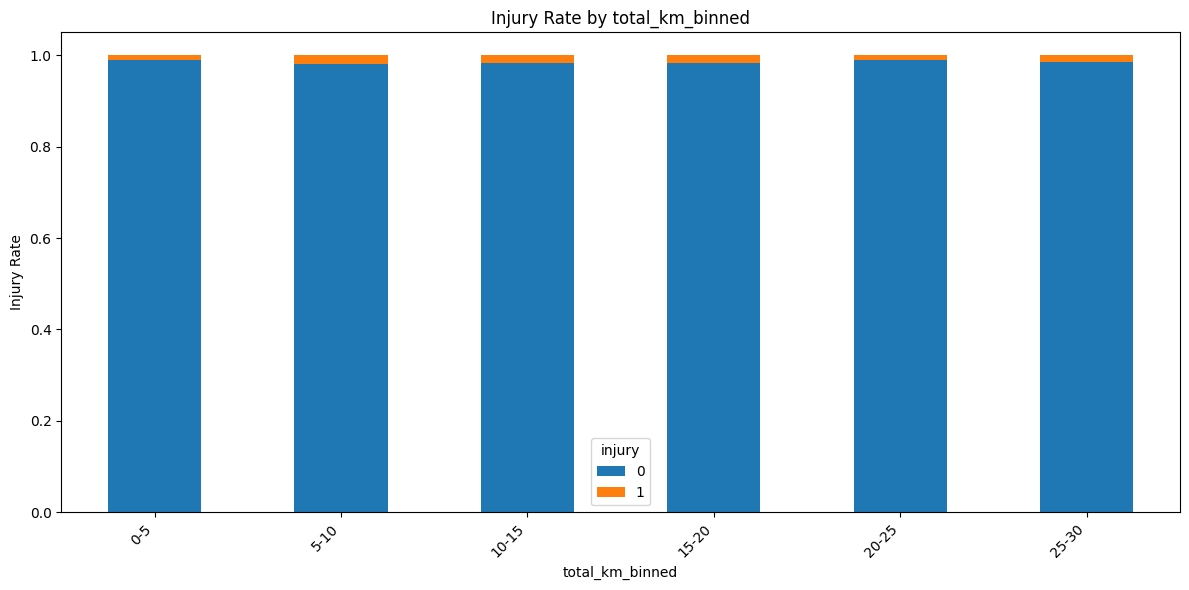

<ipython-input-14-ad261cf2707e>:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(feature)[target].value_counts(normalize=True).unstack(fill_value=0)


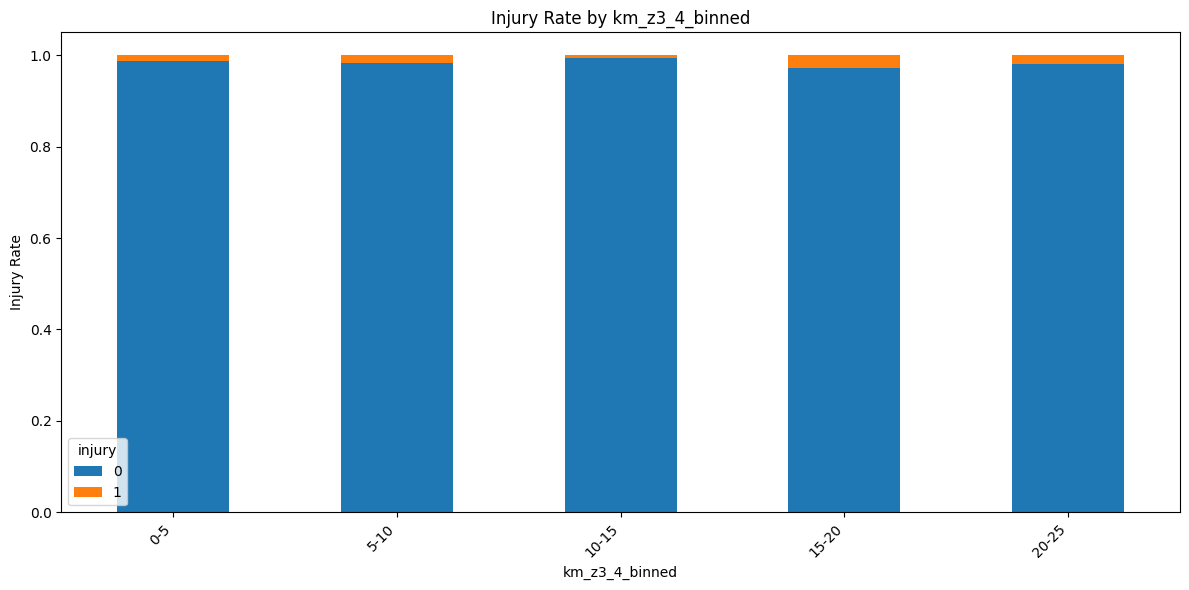

<ipython-input-14-ad261cf2707e>:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(feature)[target].value_counts(normalize=True).unstack(fill_value=0)


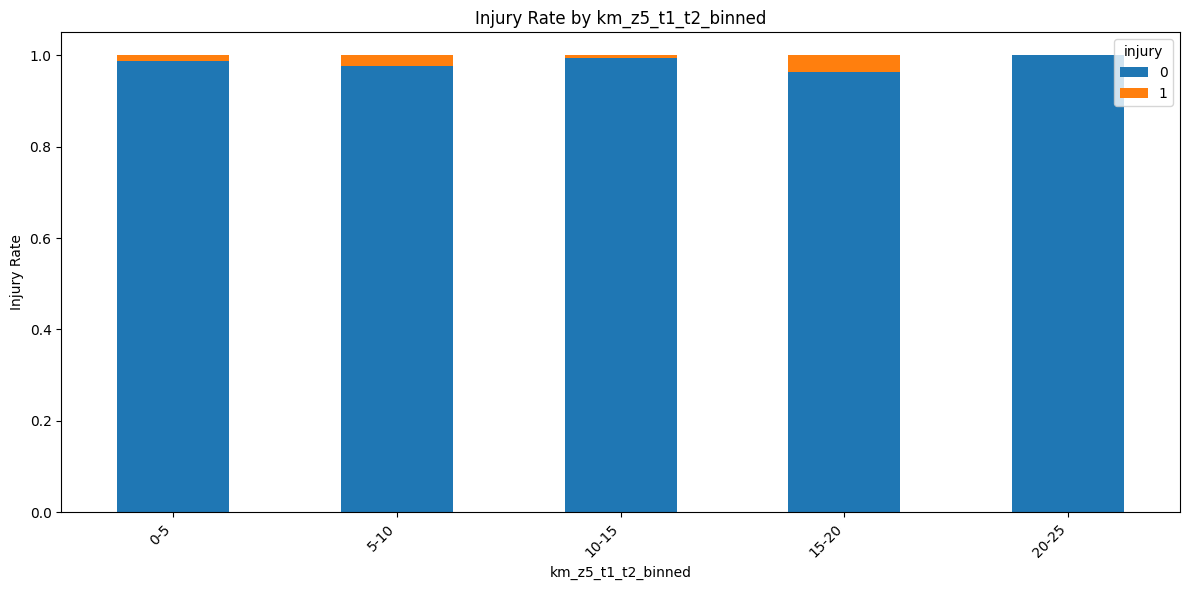

<ipython-input-14-ad261cf2707e>:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(feature)[target].value_counts(normalize=True).unstack(fill_value=0)


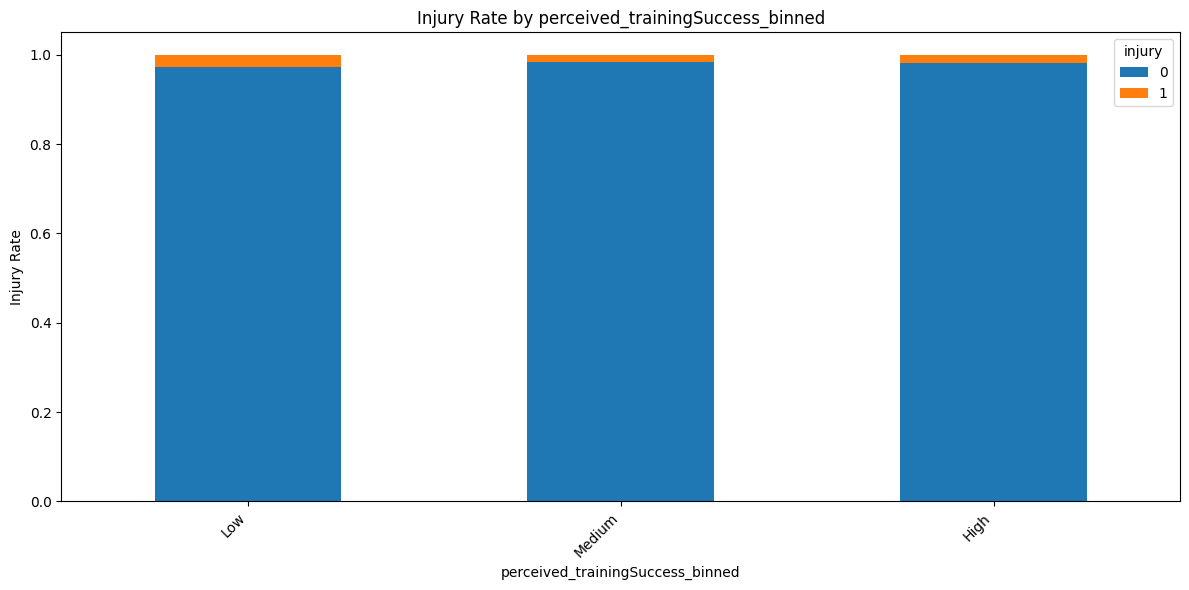

In [ ]:
import pandas as pd

# Load the dataset
daily_data = pd.read_csv('day_approach_maskedID_timeseries.csv')

# Bin for total km (based on observed range)
bins_total_km = [0, 5, 10, 15, 20, 25, 30]  # Adjust based on data's actual range
labels_total_km = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30']
daily_data['total_km_binned'] = pd.cut(daily_data['total km'], bins=bins_total_km, labels=labels_total_km, right=False)

# Bin for km Z3-4 (based on observed range)
bins_km_z3_4 = [0, 5, 10, 15, 20, 25]  # Adjust based on actual range
labels_km_z3_4 = ['0-5', '5-10', '10-15', '15-20', '20-25']
daily_data['km_z3_4_binned'] = pd.cut(daily_data['km Z3-4'], bins=bins_km_z3_4, labels=labels_km_z3_4, right=False)

# Bin for km Z5-T1-T2 (based on observed range)
bins_km_z5_t1_t2 = [0, 5, 10, 15, 20, 25]  # Adjust based on actual range
labels_km_z5_t1_t2 = ['0-5', '5-10', '10-15', '15-20', '20-25']
daily_data['km_z5_t1_t2_binned'] = pd.cut(daily_data['km Z5-T1-T2'], bins=bins_km_z5_t1_t2, labels=labels_km_z5_t1_t2, right=False)

# Bin for perceived training success (based on quantiles or custom intervals)
bins_perceived_training_success = [0, 0.33, 0.66, 1]  # Define bins
labels_perceived_training_success = ['Low', 'Medium', 'High']  # Labels for each bin
daily_data['perceived_trainingSuccess_binned'] = pd.cut(daily_data['perceived trainingSuccess'], bins=bins_perceived_training_success, labels=labels_perceived_training_success)

# Now proceed with the analysis
def analyze_feature_impact_with_bins(df, feature, target, bins=None):
    """
    Analyzes the impact of a given feature (including continuous variables binned) on the injury rate.
    Args:
    - df (pd.DataFrame): The dataset
    - feature (str): The feature column name
    - target (str): The target column name (usually 'injury')
    - bins (int or sequence): The number of bins or bin edges for the continuous feature (default=None for no binning)
    """
    # Check for missing values in feature or target columns
    if df[feature].isnull().sum() > 0 or df[target].isnull().sum() > 0:
        print(f"Warning: Missing values found in {feature} or {target}")

    # If the feature is continuous, bin the variable
    if bins is not None and df[feature].dtype in ['float64', 'int64']:
        df[feature] = pd.cut(df[feature], bins=bins, labels=False, include_lowest=True)

    # Convert to category if the feature is discrete (like nr. sessions or strength training)
    if df[feature].dtype in ['int64', 'float64']:
        df[feature] = df[feature].astype('category')

    # Group by the feature and calculate the injury rate per group
    grouped = df.groupby(feature)[target].value_counts(normalize=True).unstack(fill_value=0)

    # Plot the injury rate by feature group
    ax = grouped.plot(kind='bar', stacked=True, figsize=(12, 6), color=['#1f77b4', '#ff7f0e'])

    # Adjust x-axis labels
    plt.title(f"Injury Rate by {feature}")
    plt.ylabel("Injury Rate")
    plt.xlabel(feature)

    # Set the x-axis ticks and labels to the discrete categories (0, 1, 2)
    plt.xticks(ticks=range(len(grouped)), labels=grouped.index)

    # Rotate x-axis labels and adjust spacing
    plt.xticks(rotation=45, ha='right')  # Rotate labels and set alignment
    plt.tight_layout()  # Ensure that labels don't get cut off

    plt.show()

# Perform the analysis with the binned features
analyze_feature_impact_with_bins(daily_data, 'total_km_binned', 'injury')
analyze_feature_impact_with_bins(daily_data, 'km_z3_4_binned', 'injury')
analyze_feature_impact_with_bins(daily_data, 'km_z5_t1_t2_binned', 'injury')
analyze_feature_impact_with_bins(daily_data, 'perceived_trainingSuccess_binned', 'injury')


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3

def analyze_injury_by_feature(df, feature, bins=4):
    """
    Analyzes injury rate by feature.
    - Categorical: uses as-is
    - Continuous: bins using quantiles
    - Saves hover-enabled HTML output
    """
    print(f"\nAnalyzing feature: {feature}")

    # Use as category if small number of unique values
    if df[feature].nunique() <= bins or df[feature].dtype == 'object':
        df[f'{feature}_binned'] = df[feature].astype('category')
    else:
        df[f'{feature}_binned'] = pd.qcut(df[feature], q=bins, duplicates='drop')

    grouped = df.groupby(f'{feature}_binned')["injury"].agg(['count', 'sum'])
    grouped['injury_rate'] = grouped['sum'] / grouped['count']
    print(grouped)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=grouped.index.astype(str), y=grouped['injury_rate'], ax=ax)
    ax.set_title(f"Injury Rate by {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Injury Rate")
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save as HTML with hover
    file_safe_name = feature.replace(" ", "_").replace(".", "")
    html_path = f"/content/day_approach_{file_safe_name}.html"
    html_str = mpld3.fig_to_html(fig)
    with open(html_path, "w") as f:
        f.write(html_str)

    print(f" Saved interactive HTML to: {html_path}")
    plt.show()



Analyzing feature: strength training
                          count  sum  injury_rate
strength training_binned                         
0.0                       37871  506     0.013361
1.0                        4819   77     0.015978
2.0                          76    0     0.000000


<ipython-input-10-ffeb31bd4c02>:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(f'{feature}_binned')["injury"].agg(['count', 'sum'])


✔️ Saved interactive HTML to: /content/day_approach_strength_training.html


/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:300: M

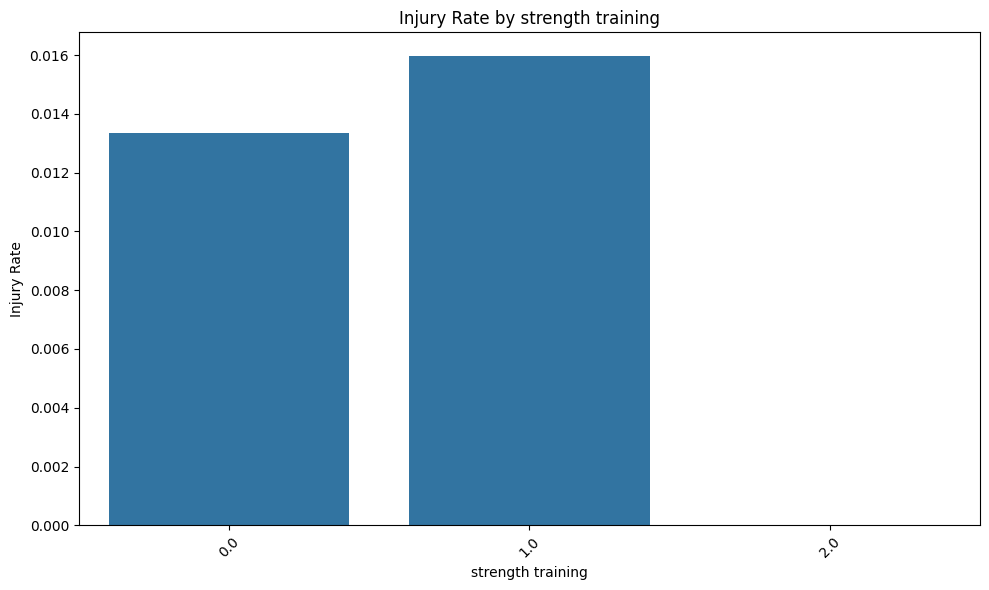

<ipython-input-10-ffeb31bd4c02>:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(f'{feature}_binned')["injury"].agg(['count', 'sum'])



Analyzing feature: nr. sessions
                     count  sum  injury_rate
nr. sessions_binned                         
0.0                  11476  100     0.008714
1.0                  27103  413     0.015238
2.0                   4187   70     0.016718
✔️ Saved interactive HTML to: /content/day_approach_nr_sessions.html


/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:300: M

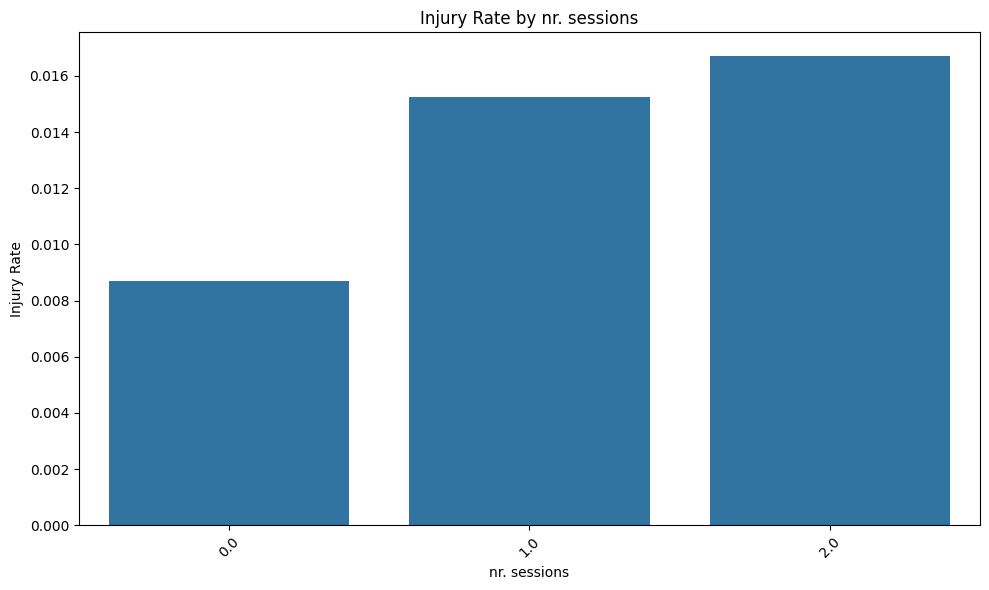

<ipython-input-10-ffeb31bd4c02>:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(f'{feature}_binned')["injury"].agg(['count', 'sum'])



Analyzing feature: total km
                 count  sum  injury_rate
total km_binned                         
(-0.001, 6.0]    21511  230     0.010692
(6.0, 12.0]      10714  191     0.017827
(12.0, 55.9]     10541  162     0.015369
✔️ Saved interactive HTML to: /content/day_approach_total_km.html


/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:300: M

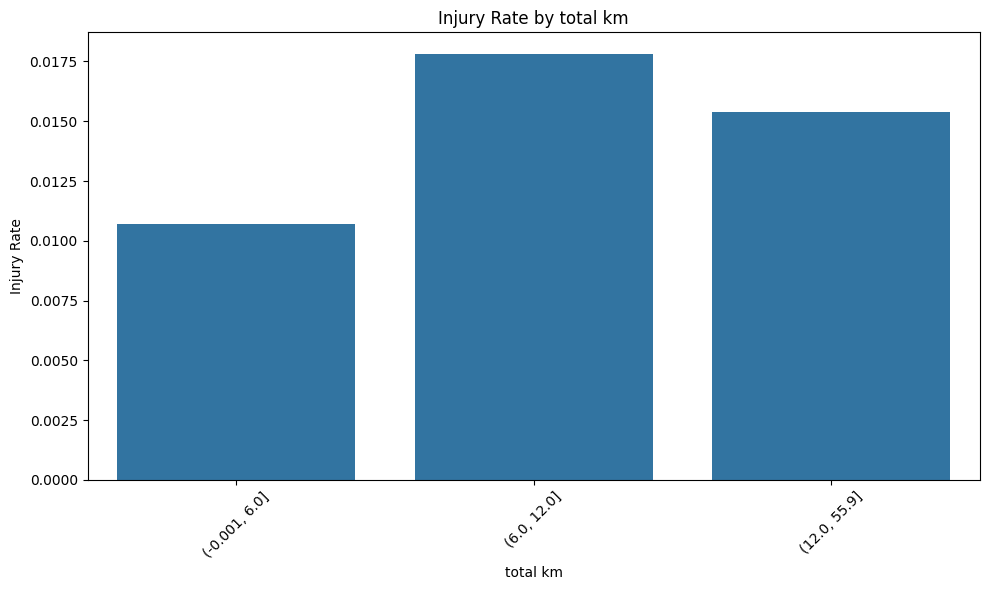

<ipython-input-10-ffeb31bd4c02>:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(f'{feature}_binned')["injury"].agg(['count', 'sum'])



Analyzing feature: km Z3-4
                count  sum  injury_rate
km Z3-4_binned                         
(-0.001, 42.2]  42766  583     0.013632
✔️ Saved interactive HTML to: /content/day_approach_km_Z3-4.html


/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:300: M

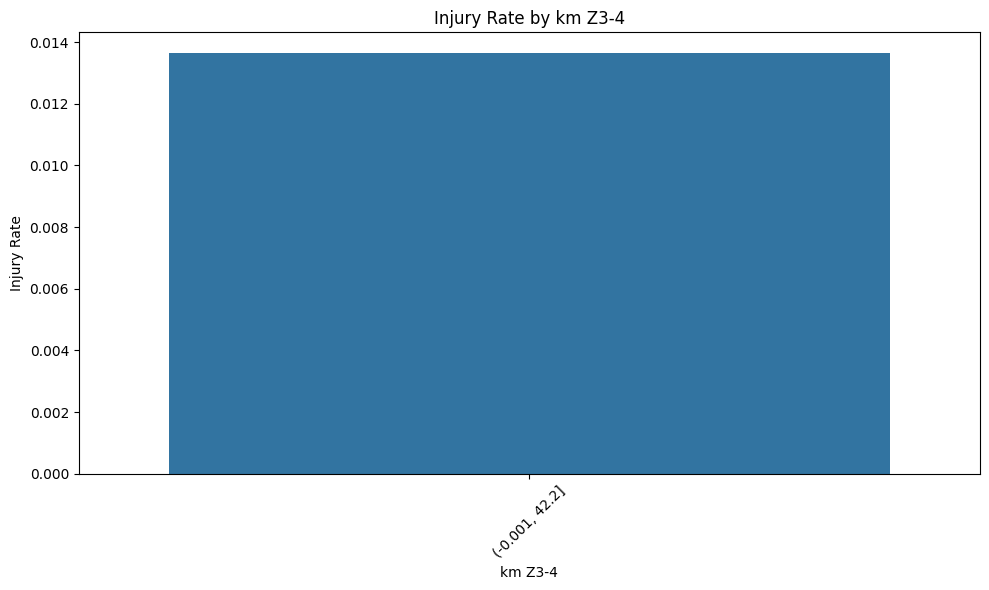

<ipython-input-10-ffeb31bd4c02>:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(f'{feature}_binned')["injury"].agg(['count', 'sum'])



Analyzing feature: km Z5-T1-T2
                    count  sum  injury_rate
km Z5-T1-T2_binned                         
(-0.001, 48.0]      42766  583     0.013632
✔️ Saved interactive HTML to: /content/day_approach_km_Z5-T1-T2.html


/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:300: M

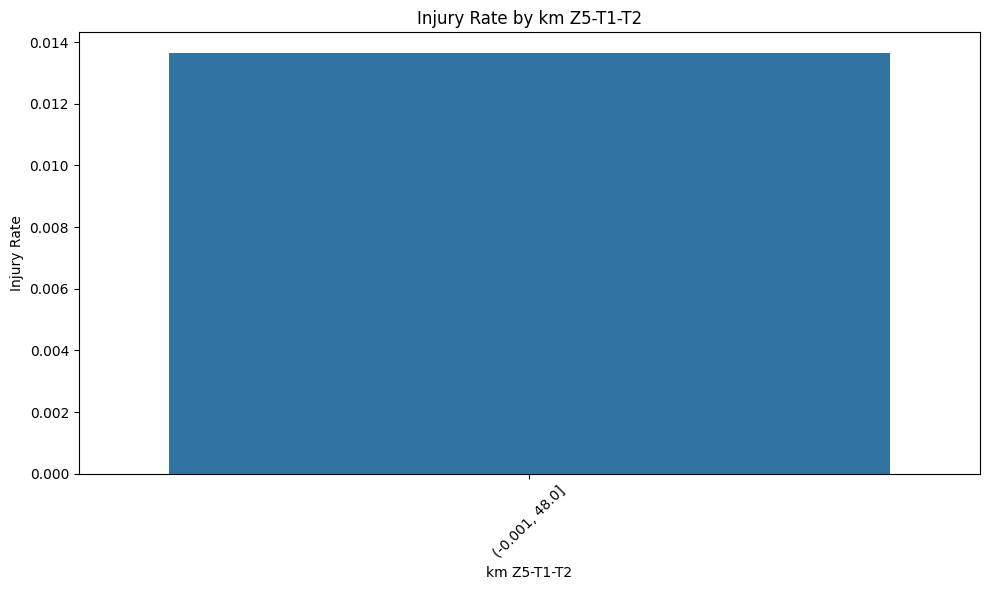

<ipython-input-10-ffeb31bd4c02>:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(f'{feature}_binned')["injury"].agg(['count', 'sum'])



Analyzing feature: perceived trainingSuccess
                                  count  sum  injury_rate
perceived trainingSuccess_binned                         
(-0.011, 0.26]                    21415  206     0.009619
(0.26, 0.72]                      10785  187     0.017339
(0.72, 1.0]                       10566  190     0.017982
✔️ Saved interactive HTML to: /content/day_approach_perceived_trainingSuccess.html


/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/utils.py:300: M

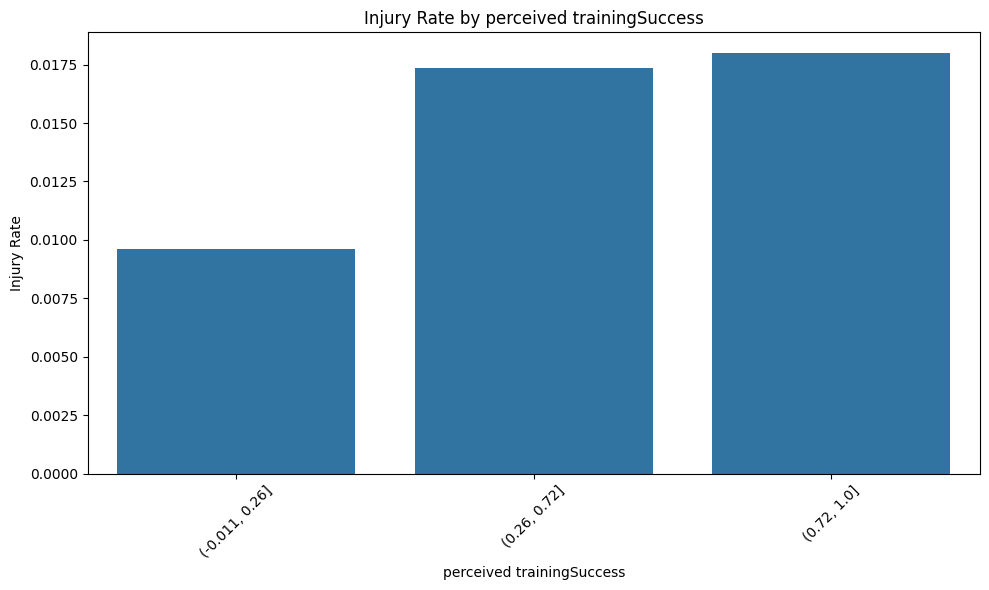

In [11]:
features = [
    "strength training",
    "nr. sessions",
    "total km",
    "km Z3-4",
    "km Z5-T1-T2",
    "perceived trainingSuccess"
]
for feat in features:
    analyze_injury_by_feature(daily_data, feat)
